In [1]:
##%matplotlib widget
## with %matplotlib notebook: seems to require ipympl as part of environment, either
## part of the conda environment or "pip install ipympl"
## otherwise, does not show ANY plots in note"book, plt.savefig() works
%matplotlib notebook  
##%matplotlib inline    ## --plt.savefig()  works, but re-sizing does NOT


This notebook is the second attempt to read in track information and use it to predict the KDE used as input to PvFinder. This time, we are reading in poca KDEs rather than the original KDEs. 

collectdata_kde_C.py uses poca_z, poca_x, poca_y, major_axis_x, major_axis_y, and major_axis_z as the six track parameters (for the moment)


Check the current GPU usage. Please try to be nice!

In [2]:
!nvidia-smi

Sun Aug 29 20:26:37 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 470.42.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA TITAN V      Off  | 00000000:03:00.0 Off |                  N/A |
| 43%   61C    P2   114W / 250W |   8775MiB / 12066MiB |     81%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  Off  | 00000000:83:00.0 Off |                    0 |
| N/A   

> **WARNING**: The card numbers here are *not* the same as in CUDA. You have been warned.

This notebook is first attempt to read in track information and use it to predict the KDE used as input to PvFinder.


## Imports

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import pandas as pd

# Python 3 standard library
from pathlib import Path

##from torchsummary import summary

### Set up local parameters

In [4]:
n_epochs = 400

# Name is the output file name


##  201027 -- about to go to bed, so try 2500 epochs with lr = 1e55
##  previous iteration had l4 = 3e-5 and cost dropped almost linearly
##  for 100 epochs -- final training costs ~ 2.02, validation cost ~ 2.01

## for iter 4, try 10 epochs with lr = 3e-6
## usually have a big jump down at epoch 0; want to try a
## small number of epochs per iteration and see what happens (iter4: 10 epochs gave
## traiing cost dropping from 1.54 to 1.50 immediately, then dropping very slowly)
folder = 'baileyds400ep_DDplus_iter4_carefulAdam'
name   = folder

# Make an output folder named "name" (change if you want)

## Special instructions for those working on goofy at UC
## Please be very careful to make sure that your folder
## does not live in a subdirectory of your home directory
## this disk has very little capacity. Instead, use 
## a subdirectory in /share/lazy with a symbolic link to
## it in this (the notebooks) subdirectory
folder = 'baileyds/DDplus/' + folder
output = Path(folder)


# Size of batches
batch_size = 16 ## was 64
# How fast to learn
learning_rate = 1e-4

Make the output directory if it does not exist:

In [5]:
output.mkdir(exist_ok=True)

## Get the helper functions

Add the directory with the model
definitions to the path so we can import from it:

> When you type `import X`,
Python searches `sys.path` for a python
file named `X.py` to import. So we need to add the model directory to the path.

In [6]:
# From model/collectdata.py
##from model.collectdata_kde_B import collect_t2kde_data
## collectdata_kde_C should use the new poca KDE rather than the original kernel KDE
from model.collectdata_kde_Ellipsoids import collect_t2kde_data


# From model/loss.py
##from loss import Loss
## kde_loss_D includes botha ratio term and a chisq term, 98% ave_chisq
## kde_loss_E adds a chi^4 term to the kde_loss_D return value
## this is intended to emphasize the importance of values significantly different than zero
from model.kde_loss_Ba import Loss

##  TracksToKDE_Ellipsoids_SevenLayerCake has 7 hidden layers producing the 4000-bin KDE historgram
##  It takes 9 input features (pocca centers + (A,B,C,D,E,F) . 
from model.models_kde import TracksToKDE_Ellipsoids_DDplus as Model


from model.training_kde import trainNet, select_gpu, Results
from functions.my_training_kde import carefultrainNet
from model.plots import dual_train_plots, replace_in_ax

In [7]:
# This gets built up during the run - do not rerun this cell
results = pd.DataFrame([], columns=Results._fields)
# my entry 
from functions.utils import get_param_state
param_states = []

Set up Torch device configuration. All tensors and model parameters need to know where to be put.
This takes a BUS ID number: The BUS ID is the same as the listing at the top of this script.

In [8]:
device = "cuda:2"#select_gpu(0)
##device = "cpu"

## Loading data

Load the dataset, split into parts, then move to device (see `collectdata.py` in the `../model` directory)

# Preparing the model

Prepare a model, use multiple GPUs if they are VISIBLE, and move the model to the device.

In [9]:
##print("Let's use", torch.cuda.device_count(), "GPUs!")
##if torch.cuda.device_count() > 1:
##    model = torch.nn.DataParallel(model)

In [10]:
## a comment on the web at https://pytorch.org/docs/stable/optim.html says
"""
If you need to move a model to GPU via .cuda(), please do so before constructing optimizers for it. 
Parameters of a model after .cuda() will be different objects with those before the call.

In general, you should make sure that optimized parameters live in consistent locations when 
optimizers are constructed and used.
"""
## so move this here (although we are using model.to(device) not explicitly using .cuda()

nOut1 = 50
nOut2 = 50
nOut3 = 50
nOut4 = 50
nOut5 = 50
nOut6 = 50
nOut7 = 50
nOut8 = 50
nOut9 = 50
nOut10 = 50
nOut11 = 50
latentChannels = 4
model = Model(nOut1,nOut2,nOut3,nOut4,nOut5,nOut6,nOut7,nOut8,nOut9,nOut10,nOut11,latentChannels)

##summary(model, input_size=(4, 4000))
##print(model.parameters)

## add the following code to allow the user to freeze the some of the weights corresponding 
## to those taken from an earlier model trained with the original target histograms
## presumably -- this leaves either the perturbative filter "fixed" and lets the 
## learning focus on the non-perturbative features, so get started faster, or vice versa
ct = 0
for child in model.children():
  print('ct, child = ',ct, "  ", child)
  if ct < 0:
    print("     About to set param.requires_grad=False for ct = ", ct, "params")
    for param in child.parameters():
        param.requires_grad = False 
  ct += 1
##  mds 200121 loss = Loss(epsilon=1e-5,coefficient=1.0)
##  loss = Loss(epsilon=1e-5,coefficient=2.5)
##loss = Loss(epsilon=3e-5, debug=False)
loss = Loss(epsilon=3e-5)

ct, child =  0    Linear(in_features=9, out_features=50, bias=True)
ct, child =  1    Linear(in_features=50, out_features=50, bias=True)
ct, child =  2    Linear(in_features=50, out_features=50, bias=True)
ct, child =  3    Linear(in_features=50, out_features=50, bias=True)
ct, child =  4    Linear(in_features=50, out_features=50, bias=True)
ct, child =  5    Linear(in_features=50, out_features=50, bias=True)
ct, child =  6    Linear(in_features=50, out_features=50, bias=True)
ct, child =  7    Linear(in_features=50, out_features=50, bias=True)
ct, child =  8    Linear(in_features=50, out_features=50, bias=True)
ct, child =  9    Linear(in_features=50, out_features=50, bias=True)
ct, child =  10    Linear(in_features=50, out_features=50, bias=True)
ct, child =  11    Linear(in_features=50, out_features=16000, bias=True)
ct, child =  12    Conv1d(4, 25, kernel_size=(25,), stride=(1,), padding=(12,))
ct, child =  13    Conv1d(25, 1, kernel_size=(5,), stride=(1,), padding=(2,))
ct, child 

Let's move the model's weight matricies to the GPU:

In [11]:
model = model.to(device)

In [12]:
from functions.mod_adam import Reversible_Adam
optimizer = Reversible_Adam(model.parameters(), lr=learning_rate)
##optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [13]:
print('output = ',output)
##print('oldOutput = ',oldOutput)
##  use the first four layers from a pre-existing model
##  see example at https://discuss.pytorch.org/t/how-to-load-part-of-pre-trained-model/1113

##   ML -> /share/lazy/sokoloff/ML
model_dict = model.state_dict()
## mds 190725 for debugging
print("for model_dict")
index = 0
for k,v in model_dict.items():
    print("index, k =  ",index,"  ",k)
    index = index+1
##    print("value = ", v)
 
updated_dict = model_dict
##print("updated_dict = ",updated_dict)
## when starting "ab initio", reduce biases as the bias gets summed for each track
## contributing to the predicted KDE
updated_dict["layer1.bias"] = 0.005*model_dict["layer1.bias"]
updated_dict["layer2.bias"] = 0.005*model_dict["layer2.bias"]
updated_dict["layer3.bias"] = 0.005*model_dict["layer3.bias"]
updated_dict["layer4.bias"] = 0.005*model_dict["layer4.bias"]
updated_dict["layer5.bias"] = 0.005*model_dict["layer5.bias"]
updated_dict["layer6.bias"] = 0.005*model_dict["layer6.bias"]
updated_dict["layer7.bias"] = 0.005*model_dict["layer7.bias"]
updated_dict["layer8.bias"] = 0.005*model_dict["layer8.bias"]
updated_dict["layer9.bias"] = 0.005*model_dict["layer9.bias"]
updated_dict["layer10.bias"] = 0.005*model_dict["layer10.bias"]
updated_dict["layer11.bias"] = 0.005*model_dict["layer11.bias"]

model.load_state_dict(updated_dict,strict=False)

model_dict = model.state_dict()
##print("updated model_dict = ",model_dict)

## print(" \n","  for pretrained_dict")
## index = 0
##for k,v in pretrained_dict.items():
##    print("index, k =  ",index,"  ",k)
##    index = index+1
## mds  

##pretrained_dict = torch.load('ML/29July2020_Trks_to_KDE_C_lossB_100epochs_b64_1m3_nOut_50x50/29July2020_Trks_to_KDE_C_lossB_100epochs_b64_1m3_nOut_50x50_final.pyt')
##print("model_dict instantiated")
# 1. filter out unnecessary keys
##pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
##print("pretrained_dict iterated")
# 2. overwrite entries in the existing state dict
##model_dict.update(pretrained_dict) 
##
#   when starting from a model with a fully connected last layer rather than a convolutional layer
# 3. load the new state dict
#   need to use strict=False as the two models state model attributes do not agree exactly
#   see https://pytorch.org/docs/master/_modules/torch/nn/modules/module.html#Module.load_state_dict

##model.load_state_dict(pretrained_dict,strict=False)

## print('model_dict =    ', model_dict)

# ## finished at training cost = 1.46, validation cost = 1.50
d_folder = 'baileyds200ep_DDplus_iter3'
d_name = d_folder
suffix = 'final'
dict_name = 'baileyds/DDplus/' + d_folder + '/' + d_name + '_'+ suffix + '.pyt'
print('dict_name = ',dict_name)
pretrained_dict = torch.load(dict_name)

# print(" ")
# print("  for pretrained_dict")
# index = 0
# for k,v in pretrained_dict.items():
#     print("index, k =  ",index,"  ",k)
#     index = index+1
 

# ##print("model_dict instantiated")
# # 1. filter out unnecessary keys
# pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
# print("pretrained_dict iterated")
# # 2. overwrite entries in the existing state dict
# model_dict.update(pretrained_dict) 
# ##
# #   when starting from a model with a fully connected last layer rather than a convolutional layer
# # 3. load the new state dict
# #   need to use strict=False as the two models state model attributes do not agree exactly
# #   see https://pytorch.org/docs/master/_modules/torch/nn/modules/module.html#Module.load_state_dict

model.load_state_dict(pretrained_dict,strict=False)

#mine
param_states.append(get_param_state(model))


output =  baileyds/DDplus/baileyds400ep_DDplus_iter4_carefulAdam
for model_dict
index, k =   0    layer1.weight
index, k =   1    layer1.bias
index, k =   2    layer2.weight
index, k =   3    layer2.bias
index, k =   4    layer3.weight
index, k =   5    layer3.bias
index, k =   6    layer4.weight
index, k =   7    layer4.bias
index, k =   8    layer5.weight
index, k =   9    layer5.bias
index, k =   10    layer6.weight
index, k =   11    layer6.bias
index, k =   12    layer7.weight
index, k =   13    layer7.bias
index, k =   14    layer8.weight
index, k =   15    layer8.bias
index, k =   16    layer9.weight
index, k =   17    layer9.bias
index, k =   18    layer10.weight
index, k =   19    layer10.bias
index, k =   20    layer11.weight
index, k =   21    layer11.bias
index, k =   22    layer12new.weight
index, k =   23    layer12new.bias
index, k =   24    conv1.weight
index, k =   25    conv1.bias
index, k =   26    conv2.weight
index, k =   27    conv2.bias
index, k =   28    fc1.wei

In [14]:
##print('validation.dataset.tensors = ',validation.dataset.tensors)
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 4
plt.rcParams["figure.figsize"] = fig_size

In [15]:

## Training dataset. You can put as many files here as desired.

##train_loader = collect_t2kde_data('/share/lazy/pv-finder/20k_evts_for_KDE_learning_200716.h5',
train_loader = collect_t2kde_data('dataAA/20K_POCA_kernel_evts_200926.h5',
##train_loader = collect_t2kde_data('/share/lazy/pv-finder/test_data_for_KDE_learning_BastilleDay20.h5',
                            batch_size=batch_size,
## if we are using a larger dataset (240K events, with the datasets above, and 11 GB  of GPU memory),
## the dataset will overflow the GPU memory; device=device will allow the data to move back
## and forth between the CPU and GPU memory. While this allows use of a larger dataset, it slows
## down performance by about 10%.  So comment out when not needed.
##                          device=device,
                           slice = slice(None,18000)
                           )
                            
# Validation dataset. You can slice to reduce the size.
## mds no separate validation set yet,
val_loader = collect_t2kde_data('dataAA/20K_POCA_kernel_evts_200926.h5',
                            batch_size=batch_size,
##                            device=device,
                            slice = slice(18000,None)
                           )


Loading data...
pocaMx.shape =  (20000,)
nEvts =  20000
len(pocaMx[0]) =  211
len(pocaMx[1]) =  21
len(pocaMx[2]) =  20
len(pocaMx[3]) =  198
len(pocaMx[4]) =  233
majorAxis.shape =  (20000, 3)
minorAxis_1.shape =  (20000, 3)
minorAxis_2.shape =  (20000, 3)
have entered six_ellipsoid_parameters
  
 
  nEvts =  20000
 iEvt, nTrks =  0 211
 iEvt, nTrks =  1 21
 iEvt, nTrks =  2 20
 iEvt, nTrks =  3 198
 iEvt, nTrks =  4 233
 iEvt, nTrks =  5 85
 iEvt, nTrks =  6 223
 iEvt, nTrks =  7 425
 iEvt, nTrks =  8 252
 iEvt, nTrks =  9 169
A.shape =  (20000,)
majorAxis[iTrk][0][0] =  -0.00023452607
majorAxis[iTrk][1][0] =  -0.00047206535
majorAxis[iTrk][2][0] =  0.096502915
minorAxis_1[iTrk][0][0] =  -15.822749
minorAxis_1[iTrk][1][0] =  7.8608756
minorAxis_1[iTrk][2][0] =  -2.6228399e-08
minorAxis_2[iTrk][0][0] =  7.860759
minorAxis_2[iTrk][1][0] =  15.822513
minorAxis_2[iTrk][2][0] =  0.096502915
  
majorAxis[iTrk][0][0] =  -0.37655562
majorAxis[iTrk][1][0] =  0.2768704
majorAxis[iTrk][2][0] = 

len(X) =  20000
len(Xlist) =  1
Loaded dataAA/20K_POCA_kernel_evts_200926.h5 in 42.1 s
outer loop X.shape =  (20000, 9, 600)
Constructing 2000 event dataset took 0.01359 s
x_t.shape =  torch.Size([2000, 9, 600])
x_t.shape[0] =  2000
x_t.shape[1] =  9
x_t.shape =  torch.Size([2000, 9, 600])


<IPython.core.display.Javascript object>


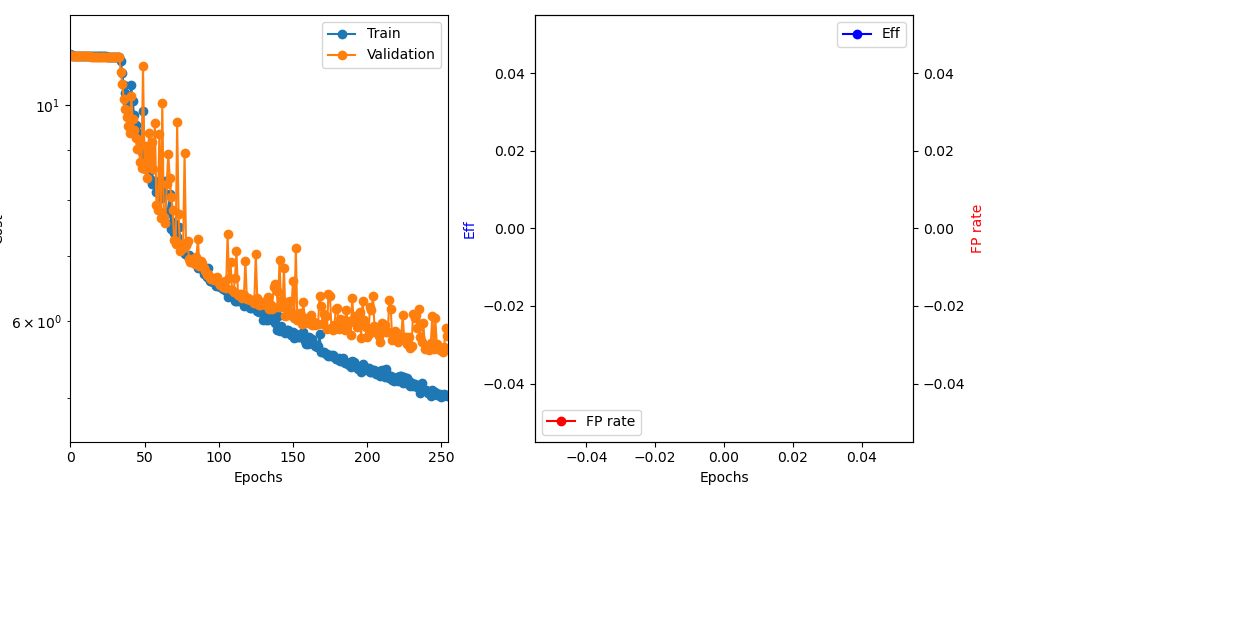

In [16]:
ax, tax, lax, lines = dual_train_plots()
fig = ax.figure
plt.tight_layout()

In [ ]:
for result in carefultrainNet(model, optimizer, loss,
                        train_loader, val_loader,
                        n_epochs, epoch_start=len(results),
                        loss_increase_limit = 0.02, lr_factor = 0.8,
                        notebook=True):
    
    results = results.append(pd.Series(result._asdict()), ignore_index=True)
    xs = results.index
    
    # Update the plot above
    lines['train'].set_data(results.index,results.cost)
    lines['val'].set_data(results.index,results.val)
    
    #filter first cost epoch (can be really large)
    max_cost = max(max(results.cost if len(results.cost)<2 else results.cost[1:]), max(results.val))
    min_cost = min(min(results.cost), min(results.val))
    
    # The plot limits need updating too
    
    
    
    ax.set_ylim(min_cost*.9, max_cost*1.1)  
    ax.set_xlim(-.5, len(results.cost) - .5)

    
    # Redraw the figure
    fig.canvas.draw()

    # Save each model state dictionary
    torch.save(model.state_dict(), output / f'{name}_{result.epoch}.pyt')
    #mine
    param_states.append(get_param_state(model))

Number of batches: train = 1125, val = 125


Number of batches: train = 1125, val = 125


new cost: 11.286160056644016 | old cost: 1000000.0
Epoch 0: train=11.2862, val=11.2517, took 250.22 s


new cost: 11.256913771311442 | old cost: 11.286160056644016
Epoch 1: train=11.2569, val=11.2494, took 253.83 s


new cost: 11.248575266944037 | old cost: 11.256913771311442
Epoch 2: train=11.2486, val=11.2375, took 251.08 s


new cost: 11.245468510945638 | old cost: 11.248575266944037
Epoch 3: train=11.2455, val=11.2461, took 246.46 s


new cost: 11.242703784094916 | old cost: 11.245468510945638
Epoch 4: train=11.2427, val=11.2421, took 251.47 s


new cost: 11.24014640850491 | old cost: 11.242703784094916
Epoch 5: train=11.2401, val=11.2363, took 251.08 s


new cost: 11.239512155744764 | old cost: 11.24014640850491
Epoch 6: train=11.2395, val=11.236, took 255.36 s


new cost: 11.236597966088189 | old cost: 11.239512155744764
Epoch 7: train=11.2366, val=11.2355, took 249.53 s


new cost: 11.235849432203505 | old cost: 11.236597966088189
Epoch 8: train=11.2358, val=11.2326, took 249.2 s


new cost: 11.235174207899306 | old cost: 11.235849432203505
Epoch 9: train=11.2352, val=11.2284, took 248.59 s


new cost: 11.23338528951009 | old cost: 11.235174207899306
Epoch 10: train=11.2334, val=11.2326, took 248.75 s


new cost: 11.232887452867296 | old cost: 11.23338528951009
Epoch 11: train=11.2329, val=11.2275, took 248.4 s


new cost: 11.232266763475206 | old cost: 11.232887452867296
Epoch 12: train=11.2323, val=11.2265, took 250.43 s


new cost: 11.230931942409939 | old cost: 11.232266763475206
Epoch 13: train=11.2309, val=11.2249, took 248.62 s


new cost: 11.230303289201524 | old cost: 11.230931942409939
Epoch 14: train=11.2303, val=11.2242, took 251.56 s


new cost: 11.229452724880643 | old cost: 11.230303289201524
Epoch 15: train=11.2295, val=11.2238, took 248.37 s


new cost: 11.22853553390503 | old cost: 11.229452724880643
Epoch 16: train=11.2285, val=11.2235, took 247.55 s


new cost: 11.228179639604356 | old cost: 11.22853553390503
Epoch 17: train=11.2282, val=11.2226, took 254.62 s


new cost: 11.227694550832112 | old cost: 11.228179639604356
Epoch 18: train=11.2277, val=11.2223, took 249.88 s


new cost: 11.227121562533908 | old cost: 11.227694550832112
Epoch 19: train=11.2271, val=11.2215, took 251.33 s


new cost: 11.226801647610134 | old cost: 11.227121562533908
Epoch 20: train=11.2268, val=11.2208, took 250.19 s


new cost: 11.225826009114583 | old cost: 11.226801647610134
Epoch 21: train=11.2258, val=11.2209, took 249.3 s


new cost: 11.226001337687174 | old cost: 11.225826009114583
Epoch 22: train=11.226, val=11.22, took 244.59 s


new cost: 11.224989206526015 | old cost: 11.226001337687174
Epoch 23: train=11.225, val=11.2206, took 246.05 s


new cost: 11.224708057403564 | old cost: 11.224989206526015
Epoch 24: train=11.2247, val=11.221, took 255.5 s


new cost: 11.223890109168158 | old cost: 11.224708057403564
Epoch 25: train=11.2239, val=11.2203, took 238.46 s


new cost: 11.223254280090332 | old cost: 11.223890109168158
Epoch 26: train=11.2233, val=11.2213, took 240.27 s


new cost: 11.222847012837727 | old cost: 11.223254280090332
Epoch 27: train=11.2228, val=11.2191, took 239.43 s


new cost: 11.222318750169542 | old cost: 11.222847012837727
Epoch 28: train=11.2223, val=11.2193, took 238.73 s


new cost: 11.222016310373942 | old cost: 11.222318750169542
Epoch 29: train=11.222, val=11.2185, took 241.61 s


new cost: 11.220576675415039 | old cost: 11.222016310373942
Epoch 30: train=11.2206, val=11.2131, took 238.89 s


new cost: 11.218544860415989 | old cost: 11.220576675415039
Epoch 31: train=11.2185, val=11.2014, took 235.8 s


new cost: 11.210318157196046 | old cost: 11.218544860415989
Epoch 32: train=11.2103, val=11.2175, took 238.26 s


new cost: 11.207784634484184 | old cost: 11.210318157196046
Epoch 33: train=11.2078, val=11.2179, took 238.5 s


new cost: 11.104132917192247 | old cost: 11.207784634484184
Epoch 34: train=11.1041, val=10.8122, took 239.15 s


new cost: 10.797957146538629 | old cost: 11.104132917192247
Epoch 35: train=10.798, val=10.5298, took 237.05 s


new cost: 10.493045461866592 | old cost: 10.797957146538629
Epoch 36: train=10.493, val=10.1403, took 238.66 s


new cost: 10.292107682969835 | old cost: 10.493045461866592
Epoch 37: train=10.2921, val=9.90583, took 240.96 s


new cost: 10.04735945892334 | old cost: 10.292107682969835
Epoch 38: train=10.0474, val=9.73604, took 243.55 s


new cost: 10.055684480879043 | old cost: 10.04735945892334
Epoch 39: train=10.0557, val=9.51816, took 248.16 s


new cost: 9.757778229607476 | old cost: 10.055684480879043
Epoch 40: train=9.75778, val=9.35556, took 243.14 s


new cost: 10.50352854707506 | old cost: 9.757778229607476
loss increase too large; model backstepping
<built-in method size of Parameter object at 0x7fcf26687320> <built-in method size of Tensor object at 0x7fcf2eb2b050>
<built-in method size of Parameter object at 0x7fcf26687050> <built-in method size of Tensor object at 0x7fcf2eb2bb40>
<built-in method size of Parameter object at 0x7fcf26687f50> <built-in method size of Tensor object at 0x7fcf2ec23cd0>
<built-in method size of Parameter object at 0x7fcf26687af0> <built-in method size of Tensor object at 0x7fcf2ecad870>
<built-in method size of Parameter object at 0x7fcf266870a0> <built-in method size of Tensor object at 0x7fcf2ecad910>
<built-in method size of Parameter object at 0x7fcf26687280> <built-in method size of Tensor object at 0x7fcf2eb2b820>
<built-in method size of Parameter object at 0x7fcf26687230> <built-in method size of Tensor object at 0x7fcf2ead15f0>
<built-in method size of Parameter object at 0x7fcf266871e0> <bui

new cost: 10.092322058783637 | old cost: 9.757778229607476
loss increase too large; model backstepping
<built-in method size of Parameter object at 0x7fcf26687320> <built-in method size of Tensor object at 0x7fcf2ee1ce10>
<built-in method size of Parameter object at 0x7fcf26687050> <built-in method size of Tensor object at 0x7fcf2ee1ce60>
<built-in method size of Parameter object at 0x7fcf26687f50> <built-in method size of Tensor object at 0x7fcf2ee1cd20>
<built-in method size of Parameter object at 0x7fcf26687af0> <built-in method size of Tensor object at 0x7fcf2ee1c1e0>
<built-in method size of Parameter object at 0x7fcf266870a0> <built-in method size of Tensor object at 0x7fcf2ee1c8c0>
<built-in method size of Parameter object at 0x7fcf26687280> <built-in method size of Tensor object at 0x7fcf2ee1c780>
<built-in method size of Parameter object at 0x7fcf26687230> <built-in method size of Tensor object at 0x7fcf2eed8730>
<built-in method size of Parameter object at 0x7fcf266871e0> <bu

new cost: 9.781296990712484 | old cost: 9.757778229607476
Epoch 43: train=9.7813, val=9.42729, took 244.64 s


new cost: 9.550437811109754 | old cost: 9.781296990712484
Epoch 44: train=9.55044, val=9.25872, took 247.69 s


new cost: 9.38385093688965 | old cost: 9.550437811109754
Epoch 45: train=9.38385, val=9.02002, took 249.47 s


new cost: 9.245963406032986 | old cost: 9.38385093688965
Epoch 46: train=9.24596, val=9.21579, took 244.92 s


new cost: 9.089394285413954 | old cost: 9.245963406032986
Epoch 47: train=9.08939, val=8.7403, took 239.74 s


new cost: 8.95080652448866 | old cost: 9.089394285413954
Epoch 48: train=8.95081, val=8.6133, took 244.58 s


new cost: 9.859899400922988 | old cost: 8.95080652448866
loss increase too large; model backstepping
<built-in method size of Parameter object at 0x7fcf26687320> <built-in method size of Tensor object at 0x7fcf1dc430f0>
<built-in method size of Parameter object at 0x7fcf26687050> <built-in method size of Tensor object at 0x7fcf1dc43cd0>
<built-in method size of Parameter object at 0x7fcf26687f50> <built-in method size of Tensor object at 0x7fcf1dc435a0>
<built-in method size of Parameter object at 0x7fcf26687af0> <built-in method size of Tensor object at 0x7fcf1dc43190>
<built-in method size of Parameter object at 0x7fcf266870a0> <built-in method size of Tensor object at 0x7fcf1dc454b0>
<built-in method size of Parameter object at 0x7fcf26687280> <built-in method size of Tensor object at 0x7fcf1dc457d0>
<built-in method size of Parameter object at 0x7fcf26687230> <built-in method size of Tensor object at 0x7fcf1dc45280>
<built-in method size of Parameter object at 0x7fcf266871e0> <buil

new cost: 8.978924538506401 | old cost: 8.95080652448866
Epoch 50: train=8.97892, val=8.60739, took 246.18 s


new cost: 8.83710705863105 | old cost: 8.978924538506401
Epoch 51: train=8.83711, val=9.08576, took 247.26 s


new cost: 8.854107160780165 | old cost: 8.83710705863105
Epoch 52: train=8.85411, val=8.41833, took 246.6 s


new cost: 8.534839230855306 | old cost: 8.854107160780165
Epoch 53: train=8.53484, val=9.36822, took 244.43 s


new cost: 8.398277654859754 | old cost: 8.534839230855306
Epoch 54: train=8.39828, val=8.72274, took 245.62 s


new cost: 8.311403558519151 | old cost: 8.398277654859754
Epoch 55: train=8.3114, val=9.16319, took 239.0 s


new cost: 8.34766060256958 | old cost: 8.311403558519151
Epoch 56: train=8.34766, val=8.59584, took 248.3 s


new cost: 8.368322311401368 | old cost: 8.34766060256958
Epoch 57: train=8.36832, val=9.5857, took 243.55 s


new cost: 8.151264151679145 | old cost: 8.368322311401368
Epoch 58: train=8.15126, val=7.89529, took 259.58 s


new cost: 8.177176266988118 | old cost: 8.151264151679145
Epoch 59: train=8.17718, val=7.81359, took 265.49 s


new cost: 8.260767414093017 | old cost: 8.177176266988118
Epoch 60: train=8.26077, val=9.33355, took 244.04 s


new cost: 8.331293589697944 | old cost: 8.260767414093017
Epoch 61: train=8.33129, val=7.66296, took 239.44 s


new cost: 8.035889445410834 | old cost: 8.331293589697944
Epoch 62: train=8.03589, val=10.0486, took 241.29 s


new cost: 8.125641237046983 | old cost: 8.035889445410834
Epoch 63: train=8.12564, val=7.68232, took 241.8 s


new cost: 8.362047384897869 | old cost: 8.125641237046983
loss increase too large; model backstepping
<built-in method size of Parameter object at 0x7fcf26687320> <built-in method size of Tensor object at 0x7fcf2ecaf1e0>
<built-in method size of Parameter object at 0x7fcf26687050> <built-in method size of Tensor object at 0x7fcf1df43e60>
<built-in method size of Parameter object at 0x7fcf26687f50> <built-in method size of Tensor object at 0x7fcf26791190>
<built-in method size of Parameter object at 0x7fcf26687af0> <built-in method size of Tensor object at 0x7fcf26791cd0>
<built-in method size of Parameter object at 0x7fcf266870a0> <built-in method size of Tensor object at 0x7fcf26791f50>
<built-in method size of Parameter object at 0x7fcf26687280> <built-in method size of Tensor object at 0x7fcf267917d0>
<built-in method size of Parameter object at 0x7fcf26687230> <built-in method size of Tensor object at 0x7fcf26791780>
<built-in method size of Parameter object at 0x7fcf266871e0> <bui

new cost: 7.7452798817952475 | old cost: 8.125641237046983
Epoch 65: train=7.74528, val=8.30845, took 233.12 s


new cost: 7.747194926367865 | old cost: 7.7452798817952475
Epoch 66: train=7.74719, val=8.921, took 242.55 s


new cost: 8.099476027594672 | old cost: 7.747194926367865
loss increase too large; model backstepping
<built-in method size of Parameter object at 0x7fcf26687320> <built-in method size of Tensor object at 0x7fcf2ee93b40>
<built-in method size of Parameter object at 0x7fcf26687050> <built-in method size of Tensor object at 0x7fcf2ee93910>
<built-in method size of Parameter object at 0x7fcf26687f50> <built-in method size of Tensor object at 0x7fcf2ee93dc0>
<built-in method size of Parameter object at 0x7fcf26687af0> <built-in method size of Tensor object at 0x7fcf2ea5cf00>
<built-in method size of Parameter object at 0x7fcf266870a0> <built-in method size of Tensor object at 0x7fcf2ea5cbe0>
<built-in method size of Parameter object at 0x7fcf26687280> <built-in method size of Tensor object at 0x7fcf2ea5cc30>
<built-in method size of Parameter object at 0x7fcf26687230> <built-in method size of Tensor object at 0x7fcf2ea5c550>
<built-in method size of Parameter object at 0x7fcf266871e0> <bui

new cost: 7.4620958819919165 | old cost: 7.747194926367865
Epoch 68: train=7.4621, val=8.05676, took 240.75 s


new cost: 7.586959773593478 | old cost: 7.4620958819919165
Epoch 69: train=7.58696, val=7.80607, took 243.21 s


new cost: 7.39231097624037 | old cost: 7.586959773593478
Epoch 70: train=7.39231, val=7.27354, took 243.57 s


new cost: 7.364653860727946 | old cost: 7.39231097624037
Epoch 71: train=7.36465, val=7.19639, took 241.83 s


new cost: 7.32771080186632 | old cost: 7.364653860727946
Epoch 72: train=7.32771, val=9.60251, took 242.34 s


new cost: 7.492171962738037 | old cost: 7.32771080186632
loss increase too large; model backstepping
<built-in method size of Parameter object at 0x7fcf26687320> <built-in method size of Tensor object at 0x7fcf2ec07d70>
<built-in method size of Parameter object at 0x7fcf26687050> <built-in method size of Tensor object at 0x7fcf2ec07af0>
<built-in method size of Parameter object at 0x7fcf26687f50> <built-in method size of Tensor object at 0x7fcf2ec077d0>
<built-in method size of Parameter object at 0x7fcf26687af0> <built-in method size of Tensor object at 0x7fcf2ec07c80>
<built-in method size of Parameter object at 0x7fcf266870a0> <built-in method size of Tensor object at 0x7fcf2ec079b0>
<built-in method size of Parameter object at 0x7fcf26687280> <built-in method size of Tensor object at 0x7fcf2ec07140>
<built-in method size of Parameter object at 0x7fcf26687230> <built-in method size of Tensor object at 0x7fcf2ec07cd0>
<built-in method size of Parameter object at 0x7fcf266871e0> <buil

new cost: 7.180927909427219 | old cost: 7.32771080186632
Epoch 74: train=7.18093, val=7.08437, took 242.84 s


new cost: 7.180939398023817 | old cost: 7.180927909427219
Epoch 75: train=7.18094, val=7.19466, took 242.21 s


new cost: 7.201281479729547 | old cost: 7.180939398023817
Epoch 76: train=7.20128, val=7.13313, took 240.93 s


new cost: 7.036415348052978 | old cost: 7.201281479729547
Epoch 77: train=7.03642, val=8.92853, took 239.85 s


new cost: 7.183115553749932 | old cost: 7.036415348052978
loss increase too large; model backstepping
<built-in method size of Parameter object at 0x7fcf26687320> <built-in method size of Tensor object at 0x7fcf2eca9c80>
<built-in method size of Parameter object at 0x7fcf26687050> <built-in method size of Tensor object at 0x7fcf2eca9960>
<built-in method size of Parameter object at 0x7fcf26687f50> <built-in method size of Tensor object at 0x7fcf2eca9460>
<built-in method size of Parameter object at 0x7fcf26687af0> <built-in method size of Tensor object at 0x7fcf2ec46cd0>
<built-in method size of Parameter object at 0x7fcf266870a0> <built-in method size of Tensor object at 0x7fcf2ec46410>
<built-in method size of Parameter object at 0x7fcf26687280> <built-in method size of Tensor object at 0x7fcf2ec46870>
<built-in method size of Parameter object at 0x7fcf26687230> <built-in method size of Tensor object at 0x7fcf2ec465a0>
<built-in method size of Parameter object at 0x7fcf266871e0> <bui

new cost: 7.000045335769653 | old cost: 7.036415348052978
Epoch 79: train=7.00005, val=7.2473, took 240.96 s


new cost: 7.017404909345839 | old cost: 7.000045335769653
Epoch 80: train=7.0174, val=6.95035, took 241.28 s


new cost: 6.969793698628743 | old cost: 7.017404909345839
Epoch 81: train=6.96979, val=6.89511, took 238.8 s


new cost: 6.902986050711737 | old cost: 6.969793698628743
Epoch 82: train=6.90299, val=6.95351, took 234.28 s


new cost: 6.909811693615383 | old cost: 6.902986050711737
Epoch 83: train=6.90981, val=6.91298, took 243.88 s


new cost: 6.9338365427653 | old cost: 6.909811693615383
Epoch 84: train=6.93384, val=6.86462, took 242.81 s


new cost: 6.886003535588582 | old cost: 6.9338365427653
Epoch 85: train=6.886, val=6.98684, took 243.11 s


new cost: 6.808737191730075 | old cost: 6.886003535588582
Epoch 86: train=6.80874, val=7.28592, took 239.2 s


new cost: 6.817480227152506 | old cost: 6.808737191730075
Epoch 87: train=6.81748, val=6.83961, took 240.97 s


new cost: 6.849411440319485 | old cost: 6.817480227152506
Epoch 88: train=6.84941, val=6.92649, took 243.06 s


new cost: 6.785848649978638 | old cost: 6.849411440319485
Epoch 89: train=6.78585, val=6.88821, took 238.44 s


new cost: 6.711369710710313 | old cost: 6.785848649978638
Epoch 90: train=6.71137, val=6.8012, took 230.6 s


new cost: 6.706093968285455 | old cost: 6.711369710710313
Epoch 91: train=6.70609, val=6.75061, took 240.59 s


new cost: 6.66837979973687 | old cost: 6.706093968285455
Epoch 92: train=6.66838, val=6.69519, took 240.49 s


new cost: 6.80281196445889 | old cost: 6.66837979973687
loss increase too large; model backstepping
<built-in method size of Parameter object at 0x7fcf26687320> <built-in method size of Tensor object at 0x7fcf2ea24be0>
<built-in method size of Parameter object at 0x7fcf26687050> <built-in method size of Tensor object at 0x7fcf2ea24e10>
<built-in method size of Parameter object at 0x7fcf26687f50> <built-in method size of Tensor object at 0x7fcf2ea24aa0>
<built-in method size of Parameter object at 0x7fcf26687af0> <built-in method size of Tensor object at 0x7fcf2ea24f00>
<built-in method size of Parameter object at 0x7fcf266870a0> <built-in method size of Tensor object at 0x7fcf2ea246e0>
<built-in method size of Parameter object at 0x7fcf26687280> <built-in method size of Tensor object at 0x7fcf2ea24870>
<built-in method size of Parameter object at 0x7fcf26687230> <built-in method size of Tensor object at 0x7fcf2ea24b90>
<built-in method size of Parameter object at 0x7fcf266871e0> <built

new cost: 6.603721761703492 | old cost: 6.66837979973687
Epoch 94: train=6.60372, val=6.65149, took 239.54 s


new cost: 6.59230203904046 | old cost: 6.603721761703492
Epoch 95: train=6.5923, val=6.62433, took 232.8 s


new cost: 6.576383570565118 | old cost: 6.59230203904046
Epoch 96: train=6.57638, val=6.64728, took 231.71 s


new cost: 6.579864671707154 | old cost: 6.576383570565118
Epoch 97: train=6.57986, val=6.61144, took 233.09 s


new cost: 6.523699480056763 | old cost: 6.579864671707154
Epoch 98: train=6.5237, val=6.6314, took 236.49 s


new cost: 6.567860300064087 | old cost: 6.523699480056763
Epoch 99: train=6.56786, val=6.65981, took 232.98 s


new cost: 6.519314136717054 | old cost: 6.567860300064087
Epoch 100: train=6.51931, val=6.57562, took 235.75 s


new cost: 6.512528706232707 | old cost: 6.519314136717054
Epoch 101: train=6.51253, val=6.54328, took 236.43 s


new cost: 6.504433316336738 | old cost: 6.512528706232707
Epoch 102: train=6.50443, val=6.56679, took 232.74 s


new cost: 6.48248093647427 | old cost: 6.504433316336738
Epoch 103: train=6.48248, val=6.50511, took 235.16 s


new cost: 6.468413331985474 | old cost: 6.48248093647427
Epoch 104: train=6.46841, val=6.60018, took 234.14 s


new cost: 6.441773812611898 | old cost: 6.468413331985474
Epoch 105: train=6.44177, val=6.49799, took 235.45 s


new cost: 6.3497904864417185 | old cost: 6.441773812611898
Epoch 106: train=6.34979, val=7.37146, took 235.23 s


new cost: 6.4593671003977455 | old cost: 6.3497904864417185
Epoch 107: train=6.45937, val=6.64198, took 234.47 s


new cost: 6.362414026896158 | old cost: 6.4593671003977455
Epoch 108: train=6.36241, val=6.90663, took 237.35 s


new cost: 6.401179410934448 | old cost: 6.362414026896158
Epoch 109: train=6.40118, val=6.4655, took 243.9 s


new cost: 6.378754823260837 | old cost: 6.401179410934448
Epoch 110: train=6.37875, val=6.42466, took 241.59 s


new cost: 6.298447221544054 | old cost: 6.378754823260837
Epoch 111: train=6.29845, val=6.6464, took 242.86 s


new cost: 6.289774390326606 | old cost: 6.298447221544054
Epoch 112: train=6.28977, val=7.0918, took 239.64 s


new cost: 6.295277718014187 | old cost: 6.289774390326606
Epoch 113: train=6.29528, val=6.38045, took 233.55 s


new cost: 6.303231461207072 | old cost: 6.295277718014187
Epoch 114: train=6.30323, val=6.39213, took 243.27 s


new cost: 6.327757925245497 | old cost: 6.303231461207072
Epoch 115: train=6.32776, val=6.40019, took 242.96 s


new cost: 6.311302745607164 | old cost: 6.327757925245497
Epoch 116: train=6.3113, val=6.33981, took 242.74 s


new cost: 6.2142108535766605 | old cost: 6.311302745607164
Epoch 117: train=6.21421, val=6.37715, took 241.85 s


new cost: 6.242688918007745 | old cost: 6.2142108535766605
Epoch 118: train=6.24269, val=6.91783, took 241.77 s


new cost: 6.2438201482560896 | old cost: 6.242688918007745
Epoch 119: train=6.24382, val=6.3285, took 241.85 s


new cost: 6.266179129918417 | old cost: 6.2438201482560896
Epoch 120: train=6.26618, val=6.33951, took 242.61 s


new cost: 6.196870850457086 | old cost: 6.266179129918417
Epoch 121: train=6.19687, val=6.3079, took 237.78 s


new cost: 6.190239967134263 | old cost: 6.196870850457086
Epoch 122: train=6.19024, val=6.31039, took 246.06 s


new cost: 6.211047745174832 | old cost: 6.190239967134263
Epoch 123: train=6.21105, val=6.31102, took 243.43 s


new cost: 6.252341195848253 | old cost: 6.211047745174832
Epoch 124: train=6.25234, val=6.27165, took 244.78 s


new cost: 6.230369527816772 | old cost: 6.252341195848253
Epoch 125: train=6.23037, val=7.03116, took 243.69 s


new cost: 6.142504529105293 | old cost: 6.230369527816772
Epoch 126: train=6.1425, val=6.3411, took 244.92 s


new cost: 6.138965923945109 | old cost: 6.142504529105293
Epoch 127: train=6.13897, val=6.2378, took 241.55 s


new cost: 6.252410644319323 | old cost: 6.138965923945109
Epoch 128: train=6.25241, val=6.23607, took 235.32 s


new cost: 6.174221652560764 | old cost: 6.252410644319323
Epoch 129: train=6.17422, val=6.2795, took 245.25 s


new cost: 6.014930340237088 | old cost: 6.174221652560764
Epoch 130: train=6.01493, val=6.25527, took 243.21 s


new cost: 6.075909150865343 | old cost: 6.014930340237088
Epoch 131: train=6.07591, val=6.25447, took 243.32 s


new cost: 6.022363185246785 | old cost: 6.075909150865343
Epoch 132: train=6.02236, val=6.22842, took 242.46 s


new cost: 6.018239149517483 | old cost: 6.022363185246785
Epoch 133: train=6.01824, val=6.36027, took 242.28 s


new cost: 6.060477541181776 | old cost: 6.018239149517483
Epoch 134: train=6.06048, val=6.17601, took 240.78 s


new cost: 6.125611026763916 | old cost: 6.060477541181776
Epoch 135: train=6.12561, val=6.23781, took 241.62 s


new cost: 6.035221621407403 | old cost: 6.125611026763916
Epoch 136: train=6.03522, val=6.18031, took 242.75 s


new cost: 6.055529489517212 | old cost: 6.035221621407403
Epoch 137: train=6.05553, val=6.5053, took 243.83 s


new cost: 5.970400478363037 | old cost: 6.055529489517212
Epoch 138: train=5.9704, val=6.54538, took 244.66 s


new cost: 5.878510123358833 | old cost: 5.970400478363037
Epoch 139: train=5.87851, val=6.45183, took 243.14 s


new cost: 6.073725540584988 | old cost: 5.878510123358833
loss increase too large; model backstepping
<built-in method size of Parameter object at 0x7fcf26687320> <built-in method size of Tensor object at 0x7fcf2e89d960>
<built-in method size of Parameter object at 0x7fcf26687050> <built-in method size of Tensor object at 0x7fcf2e89deb0>
<built-in method size of Parameter object at 0x7fcf26687f50> <built-in method size of Tensor object at 0x7fcf2e89d0f0>
<built-in method size of Parameter object at 0x7fcf26687af0> <built-in method size of Tensor object at 0x7fcf2e89d050>
<built-in method size of Parameter object at 0x7fcf266870a0> <built-in method size of Tensor object at 0x7fcf2e89dd70>
<built-in method size of Parameter object at 0x7fcf26687280> <built-in method size of Tensor object at 0x7fcf2e89dcd0>
<built-in method size of Parameter object at 0x7fcf26687230> <built-in method size of Tensor object at 0x7fcf2e89de10>
<built-in method size of Parameter object at 0x7fcf266871e0> <bui

new cost: 5.862070293638442 | old cost: 5.878510123358833
Epoch 141: train=5.86207, val=6.93324, took 242.4 s


new cost: 5.937729634814792 | old cost: 5.862070293638442
Epoch 142: train=5.93773, val=6.29307, took 240.53 s


new cost: 5.893822713851929 | old cost: 5.937729634814792
Epoch 143: train=5.89382, val=6.19874, took 241.13 s


new cost: 5.8718089794582795 | old cost: 5.893822713851929
Epoch 144: train=5.87181, val=6.80636, took 244.41 s


new cost: 5.82960621494717 | old cost: 5.8718089794582795
Epoch 145: train=5.82961, val=6.07433, took 245.1 s


new cost: 5.873569181018405 | old cost: 5.82960621494717
Epoch 146: train=5.87357, val=6.27566, took 242.79 s


new cost: 5.872343661202325 | old cost: 5.873569181018405
Epoch 147: train=5.87234, val=6.09528, took 243.61 s


new cost: 5.851967656241523 | old cost: 5.872343661202325
Epoch 148: train=5.85197, val=6.29206, took 244.18 s


new cost: 5.801106345494588 | old cost: 5.851967656241523
Epoch 149: train=5.80111, val=6.13285, took 241.14 s


new cost: 5.8489609976874455 | old cost: 5.801106345494588
Epoch 150: train=5.84896, val=6.60063, took 238.67 s


new cost: 5.769329158571032 | old cost: 5.8489609976874455
Epoch 151: train=5.76933, val=6.05018, took 243.32 s


new cost: 5.816071427875095 | old cost: 5.769329158571032
Epoch 152: train=5.81607, val=7.13691, took 243.15 s


new cost: 5.775407106187608 | old cost: 5.816071427875095
Epoch 153: train=5.77541, val=6.01706, took 244.6 s


new cost: 5.783903218163385 | old cost: 5.775407106187608
Epoch 154: train=5.7839, val=6.08932, took 241.36 s


new cost: 5.784852352990044 | old cost: 5.783903218163385
Epoch 155: train=5.78485, val=6.11148, took 243.55 s


new cost: 5.788174212137858 | old cost: 5.784852352990044
Epoch 156: train=5.78817, val=5.96654, took 242.37 s


new cost: 5.845171928829617 | old cost: 5.788174212137858
Epoch 157: train=5.84517, val=6.28186, took 234.35 s


new cost: 5.7200298720465765 | old cost: 5.845171928829617
Epoch 158: train=5.72003, val=6.04752, took 245.05 s


new cost: 5.69167636150784 | old cost: 5.7200298720465765
Epoch 159: train=5.69168, val=6.0351, took 243.45 s


new cost: 5.680720421261258 | old cost: 5.69167636150784
Epoch 160: train=5.68072, val=5.9713, took 243.45 s


new cost: 5.783971941630045 | old cost: 5.680720421261258
Epoch 161: train=5.78397, val=6.00311, took 245.47 s


new cost: 5.712394784503513 | old cost: 5.783971941630045
Epoch 162: train=5.71239, val=6.09487, took 243.23 s


new cost: 5.753525882720948 | old cost: 5.712394784503513
Epoch 163: train=5.75353, val=5.95068, took 243.66 s


new cost: 5.681702425003052 | old cost: 5.753525882720948
Epoch 164: train=5.6817, val=5.98509, took 233.62 s


new cost: 5.658486864937676 | old cost: 5.681702425003052
Epoch 165: train=5.65849, val=5.94141, took 244.79 s


new cost: 5.6468494686550565 | old cost: 5.658486864937676
Epoch 166: train=5.64685, val=5.95459, took 242.81 s


new cost: 5.653669780095418 | old cost: 5.6468494686550565
Epoch 167: train=5.65367, val=5.96406, took 243.19 s


new cost: 5.822638536877102 | old cost: 5.653669780095418
loss increase too large; model backstepping
<built-in method size of Parameter object at 0x7fcf26687320> <built-in method size of Tensor object at 0x7fcf046e65a0>
<built-in method size of Parameter object at 0x7fcf26687050> <built-in method size of Tensor object at 0x7fcf046e6e10>
<built-in method size of Parameter object at 0x7fcf26687f50> <built-in method size of Tensor object at 0x7fcf046e6230>
<built-in method size of Parameter object at 0x7fcf26687af0> <built-in method size of Tensor object at 0x7fcf046e67d0>
<built-in method size of Parameter object at 0x7fcf266870a0> <built-in method size of Tensor object at 0x7fcf046e6190>
<built-in method size of Parameter object at 0x7fcf26687280> <built-in method size of Tensor object at 0x7fcf046e6460>
<built-in method size of Parameter object at 0x7fcf26687230> <built-in method size of Tensor object at 0x7fcf046e6b40>
<built-in method size of Parameter object at 0x7fcf266871e0> <bui

new cost: 5.58220851665073 | old cost: 5.653669780095418
Epoch 169: train=5.58221, val=6.22507, took 244.7 s


new cost: 5.584434410307143 | old cost: 5.58220851665073
Epoch 170: train=5.58443, val=5.95876, took 240.91 s


new cost: 5.580436437606812 | old cost: 5.584434410307143
Epoch 171: train=5.58044, val=6.10525, took 234.31 s


new cost: 5.549677686691284 | old cost: 5.580436437606812
Epoch 172: train=5.54968, val=6.06911, took 243.45 s


new cost: 5.547927927652995 | old cost: 5.549677686691284
Epoch 173: train=5.54793, val=5.88733, took 245.27 s


new cost: 5.529225624084472 | old cost: 5.547927927652995
Epoch 174: train=5.52923, val=6.40521, took 246.38 s


new cost: 5.5317286355760364 | old cost: 5.529225624084472
Epoch 175: train=5.53173, val=6.3758, took 179.08 s


new cost: 5.540069863849216 | old cost: 5.5317286355760364
Epoch 176: train=5.54007, val=5.91151, took 88.183 s


new cost: 5.541930236392551 | old cost: 5.540069863849216
Epoch 177: train=5.54193, val=5.87245, took 86.635 s


new cost: 5.513623325771755 | old cost: 5.541930236392551
Epoch 178: train=5.51362, val=5.94325, took 86.833 s


new cost: 5.492552951812744 | old cost: 5.513623325771755
Epoch 179: train=5.49255, val=6.1811, took 87.101 s


new cost: 5.49207988357544 | old cost: 5.492552951812744
Epoch 180: train=5.49208, val=6.18433, took 86.642 s


new cost: 5.505554171244303 | old cost: 5.49207988357544
Epoch 181: train=5.50555, val=5.8907, took 86.691 s


new cost: 5.465622582965427 | old cost: 5.505554171244303
Epoch 182: train=5.46562, val=6.03642, took 86.717 s


new cost: 5.463320280287001 | old cost: 5.465622582965427
Epoch 183: train=5.46332, val=6.00252, took 86.126 s


new cost: 5.496290049870809 | old cost: 5.463320280287001
Epoch 184: train=5.49629, val=6.01693, took 86.998 s


new cost: 5.441340130064223 | old cost: 5.496290049870809
Epoch 185: train=5.44134, val=5.87448, took 88.078 s


new cost: 5.444707444508871 | old cost: 5.441340130064223
Epoch 186: train=5.44471, val=6.16663, took 85.649 s


new cost: 5.428977437761095 | old cost: 5.444707444508871
Epoch 187: train=5.42898, val=5.96958, took 88.785 s


new cost: 5.415505212571886 | old cost: 5.428977437761095
Epoch 188: train=5.41551, val=5.99791, took 86.439 s


new cost: 5.380816946241591 | old cost: 5.415505212571886
Epoch 189: train=5.38082, val=5.80405, took 86.661 s


new cost: 5.456334806018406 | old cost: 5.380816946241591
Epoch 190: train=5.45633, val=6.34438, took 87.102 s


new cost: 5.4480095744662815 | old cost: 5.456334806018406
Epoch 191: train=5.44801, val=5.98354, took 86.947 s


new cost: 5.423854332605997 | old cost: 5.4480095744662815
Epoch 192: train=5.42385, val=6.07465, took 89.128 s


new cost: 5.395871142493354 | old cost: 5.423854332605997
Epoch 193: train=5.39587, val=5.91787, took 87.401 s


new cost: 5.364274966345893 | old cost: 5.395871142493354
Epoch 194: train=5.36427, val=6.00097, took 87.081 s


new cost: 5.383728479597304 | old cost: 5.364274966345893
Epoch 195: train=5.38373, val=6.12916, took 86.085 s


new cost: 5.325651491589016 | old cost: 5.383728479597304
Epoch 196: train=5.32565, val=5.77063, took 86.12 s


new cost: 5.419268797768487 | old cost: 5.325651491589016
Epoch 197: train=5.41927, val=6.29574, took 86.464 s


new cost: 5.3438580691019695 | old cost: 5.419268797768487
Epoch 198: train=5.34386, val=6.01095, took 86.952 s


new cost: 5.365258916431003 | old cost: 5.3438580691019695
Epoch 199: train=5.36526, val=5.91967, took 86.639 s


new cost: 5.372176684061686 | old cost: 5.365258916431003
Epoch 200: train=5.37218, val=5.7751, took 86.641 s


new cost: 5.369345299402872 | old cost: 5.372176684061686
Epoch 201: train=5.36935, val=5.81864, took 86.66 s


new cost: 5.324601633071899 | old cost: 5.369345299402872
Epoch 202: train=5.3246, val=6.20937, took 86.991 s


new cost: 5.324521120495266 | old cost: 5.324601633071899
Epoch 203: train=5.32452, val=6.16659, took 86.819 s


new cost: 5.340506239149305 | old cost: 5.324521120495266
Epoch 204: train=5.34051, val=6.3633, took 88.968 s


new cost: 5.3438499836391875 | old cost: 5.340506239149305
Epoch 205: train=5.34385, val=5.9281, took 87.441 s


new cost: 5.298792382770115 | old cost: 5.3438499836391875
Epoch 206: train=5.29879, val=5.87588, took 86.968 s


new cost: 5.303515191608005 | old cost: 5.298792382770115
Epoch 207: train=5.30352, val=5.83656, took 86.383 s


new cost: 5.337543635050456 | old cost: 5.303515191608005
Epoch 208: train=5.33754, val=5.79566, took 85.992 s


new cost: 5.268931061002943 | old cost: 5.337543635050456
Epoch 209: train=5.26893, val=5.71618, took 86.315 s


new cost: 5.345593209372627 | old cost: 5.268931061002943
Epoch 210: train=5.34559, val=5.97236, took 86.231 s


new cost: 5.2949788648817275 | old cost: 5.345593209372627
Epoch 211: train=5.29498, val=5.9266, took 87.762 s


new cost: 5.258996975792779 | old cost: 5.2949788648817275
Epoch 212: train=5.259, val=5.95021, took 87.299 s


new cost: 5.360706609090169 | old cost: 5.258996975792779
Epoch 213: train=5.36071, val=5.84987, took 86.936 s


new cost: 5.285509913974338 | old cost: 5.360706609090169
Epoch 214: train=5.28551, val=5.84897, took 87.219 s


new cost: 5.245654236051771 | old cost: 5.285509913974338
Epoch 215: train=5.24565, val=6.30359, took 86.649 s


new cost: 5.2714543056488035 | old cost: 5.245654236051771
Epoch 216: train=5.27145, val=6.17138, took 86.335 s


new cost: 5.2178315111796065 | old cost: 5.2714543056488035
Epoch 217: train=5.21783, val=5.74009, took 90.871 s


new cost: 5.21470196639167 | old cost: 5.2178315111796065
Epoch 218: train=5.2147, val=5.80492, took 87.461 s


new cost: 5.224996726777818 | old cost: 5.21470196639167
Epoch 219: train=5.225, val=5.86585, took 86.468 s


new cost: 5.260672558466593 | old cost: 5.224996726777818
Epoch 220: train=5.26067, val=5.83837, took 86.597 s


new cost: 5.211848895602756 | old cost: 5.260672558466593
Epoch 221: train=5.21185, val=5.7121, took 87.205 s


new cost: 5.269075656043158 | old cost: 5.211848895602756
Epoch 222: train=5.26908, val=5.77378, took 86.488 s


new cost: 5.266494635687934 | old cost: 5.269075656043158
Epoch 223: train=5.26649, val=5.75802, took 87.518 s


new cost: 5.184742416169908 | old cost: 5.266494635687934
Epoch 224: train=5.18474, val=6.09401, took 86.611 s


new cost: 5.259503423055013 | old cost: 5.184742416169908
Epoch 225: train=5.2595, val=5.77451, took 86.697 s


new cost: 5.181729159249199 | old cost: 5.259503423055013
Epoch 226: train=5.18173, val=5.78346, took 87.166 s


new cost: 5.240126434750027 | old cost: 5.181729159249199
Epoch 227: train=5.24013, val=5.69167, took 88.385 s


new cost: 5.204034411324395 | old cost: 5.240126434750027
Epoch 228: train=5.20403, val=5.77794, took 87.014 s


new cost: 5.1533639948103165 | old cost: 5.204034411324395
Epoch 229: train=5.15336, val=5.63701, took 86.898 s


new cost: 5.180489220937093 | old cost: 5.1533639948103165
Epoch 230: train=5.18049, val=5.65201, took 86.36 s


new cost: 5.144265823576186 | old cost: 5.180489220937093
Epoch 231: train=5.14427, val=6.10204, took 86.687 s


new cost: 5.168353704452515 | old cost: 5.144265823576186
Epoch 232: train=5.16835, val=6.04565, took 86.662 s


new cost: 5.153872771792941 | old cost: 5.168353704452515
Epoch 233: train=5.15387, val=6.08552, took 86.623 s


new cost: 5.13263378821479 | old cost: 5.153872771792941
Epoch 234: train=5.13263, val=5.91138, took 86.967 s


new cost: 5.124213422139485 | old cost: 5.13263378821479
Epoch 235: train=5.12421, val=6.18063, took 86.722 s


new cost: 5.065768934885661 | old cost: 5.124213422139485
Epoch 236: train=5.06577, val=5.77552, took 86.46 s


new cost: 5.184044176949395 | old cost: 5.065768934885661
loss increase too large; model backstepping
<built-in method size of Parameter object at 0x7fcf26687320> <built-in method size of Tensor object at 0x7fcef19660f0>
<built-in method size of Parameter object at 0x7fcf26687050> <built-in method size of Tensor object at 0x7fcf2656b050>
<built-in method size of Parameter object at 0x7fcf26687f50> <built-in method size of Tensor object at 0x7fcf2656b550>
<built-in method size of Parameter object at 0x7fcf26687af0> <built-in method size of Tensor object at 0x7fcf2656beb0>
<built-in method size of Parameter object at 0x7fcf266870a0> <built-in method size of Tensor object at 0x7fcf2656bf00>
<built-in method size of Parameter object at 0x7fcf26687280> <built-in method size of Tensor object at 0x7fcf2656bcd0>
<built-in method size of Parameter object at 0x7fcf26687230> <built-in method size of Tensor object at 0x7fcf26515e60>
<built-in method size of Parameter object at 0x7fcf266871e0> <bui

new cost: 5.098501115587022 | old cost: 5.065768934885661
Epoch 238: train=5.0985, val=5.97049, took 86.517 s


new cost: 5.10376159286499 | old cost: 5.098501115587022
Epoch 239: train=5.10376, val=5.61899, took 87.448 s


new cost: 5.094308767318726 | old cost: 5.10376159286499
Epoch 240: train=5.09431, val=5.63019, took 86.454 s


new cost: 5.058919535742866 | old cost: 5.094308767318726
Epoch 241: train=5.05892, val=5.64858, took 86.949 s


new cost: 5.07840974383884 | old cost: 5.058919535742866
Epoch 242: train=5.07841, val=5.60704, took 87.357 s


new cost: 5.033000865724351 | old cost: 5.07840974383884
Epoch 243: train=5.033, val=5.69954, took 86.971 s


new cost: 5.0963188675774465 | old cost: 5.033000865724351
Epoch 244: train=5.09632, val=6.07367, took 86.844 s


new cost: 5.0628953319125705 | old cost: 5.0963188675774465
Epoch 245: train=5.0629, val=5.62087, took 86.964 s


new cost: 5.072955540339152 | old cost: 5.0628953319125705
Epoch 246: train=5.07296, val=6.04284, took 86.489 s


new cost: 5.0383899154663085 | old cost: 5.072955540339152
Epoch 247: train=5.03839, val=5.68888, took 87.188 s


new cost: 5.046284695095486 | old cost: 5.0383899154663085
Epoch 248: train=5.04628, val=5.65012, took 86.727 s


new cost: 5.046909816106161 | old cost: 5.046284695095486
Epoch 249: train=5.04691, val=5.59954, took 86.481 s


new cost: 5.01318877029419 | old cost: 5.046909816106161
Epoch 250: train=5.01319, val=5.62056, took 86.698 s


new cost: 5.028868933783637 | old cost: 5.01318877029419
Epoch 251: train=5.02887, val=5.58111, took 86.681 s


new cost: 5.0539768274095325 | old cost: 5.028868933783637
Epoch 252: train=5.05398, val=5.6508, took 88.158 s


new cost: 5.0415468300713435 | old cost: 5.0539768274095325
Epoch 253: train=5.04155, val=5.90497, took 87.115 s


new cost: 5.029376925150554 | old cost: 5.0415468300713435
Epoch 254: train=5.02938, val=5.79369, took 87.797 s


Go ahead and save the final model (even though it was also saved above):

In [ ]:
torch.save(model.state_dict(), output / f'{name}_final.pyt')

Save the output results:

In [ ]:
results.to_hdf(f'{name}_stats.hdf5', 'results')

Save the plot above:

In [ ]:
dual_train_plots(results.index,
                 results.cost, results.val,
                 results.cost, results.val)
plt.tight_layout()
plt.savefig(str(output / f'{name}_stats_a.png'))

In [ ]:
from functions.utils import state_dict_to_vector
def angle_between(a, b):
    return np.arccos(np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b)))

angle_grids = []
grid_size = 25
num_epochs = n_epochs
num_epochs2 = 0

ep_intervals = [(np.arange(0, num_epochs+num_epochs2+1, grid_size)[i], np.arange(0, num_epochs+num_epochs2+1, grid_size)[i+1]) for i in range(len(np.arange(0, num_epochs+num_epochs2+1, grid_size))-1)]

for interval in ep_intervals:
    
    these_param_states = []
    for i in range(interval[0], interval[1]):
        if i % 100 == 0:
            print(i)
        these_param_states.append(param_states[i])
        #print("Loaded", file_names[i])
        
    interval_size = len(these_param_states)-1    
    these_steps = [these_param_states[i+1]-these_param_states[i] for i in range(interval_size)]
    
    this_angle_grid = np.zeros((interval_size, interval_size))
    
    for i in range(interval_size):
        for j in range(i+1, interval_size):#range(i+1, interval_size):
            angle = angle_between(these_steps[i], these_steps[j])
            this_angle_grid[i,j] = angle
            this_angle_grid[j,i] = angle
            
    angle_grids.append(this_angle_grid)

In [ ]:
import matplotlib.colors as colors
import matplotlib.cm as cm

for angle_grid in angle_grids:
    plt.figure(figsize=(12,8))
    norm = colors.Normalize(vmin=np.amin(angle_grid), vmax=np.amax(angle_grid))   
    plt.imshow(angle_grid, cmap=cm.jet)
    plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cm.jet))
    plt.xlabel('Step i')
    plt.ylabel('Step j')
    
#print("num params:", len(these_param_states[0]))

In [ ]:
from functions.plotting_DDplus_hists import load_data
from functions.utils import vector_to_state_dict

state_dicts = []
# num_epochs = 500
for i in np.arange(0, num_epochs, 10):
    state_dicts.append( (i, vector_to_state_dict(param_states[i], model)) )

data = load_data()

In [ ]:
from functions.plotting_DDplus_hists import plot_DDplus_hists as Plot
Plot(state_dicts, data)